In [ ]:
!pip install pyreadstat

import pyreadstat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore


%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Macbook/Dissertation/SPSS/industry.SAV"
data, meta = pyreadstat.read_sav(file_path)
data.head()

Mounted at /content/drive


,INTNR,dsk2,nace,Q002.1,Q002.2,fin_nace,TQ002.3o,Q003,Q003o,Q004,...,Q033.4,Q033.5,Q033.7,Q034,region,profit_before_tax2021,net_profit2021,avgWage,numInsured2,avgWage2
0,3305.0,2.0,23.0,2.0,32.0,32.0,"Aliuminio langai,fasadai.",1.0,NaN,1.0,...,0.0,0.0,2020.0,1.0,6.0,36551.0,30752.0,NaN,0.0,NaN
1,4023.0,1.0,27.0,2.0,32.0,32.0,Medicinininių elektroninių prietaisų gamyba,1.0,NaN,2.0,...,5.0,0.0,2017.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN
2,3.0,2.0,16.0,2.0,32.0,32.0,Malkos,8.0,15.0,4.0,...,0.0,0.0,2012.0,1.0,10.0,NaN,NaN,NaN,0.0,NaN
3,290.0,2.0,26.0,2.0,32.0,32.0,"medicininė įranga, inkubatoriai",8.0,10.0,3.0,...,4.0,0.0,2010.0,1.0,2.0,NaN,NaN,NaN,0.0,NaN
4,1767.0,2.0,25.0,2.0,32.0,32.0,Centrinio šildymo radiatorių ir katilų gamyba,1.0,NaN,1.0,...,3.0,NaN,2008.0,1.0,2.0,327308.0,273056.0,NaN,0.0,NaN


In [3]:
# Identify columns that start with "TQ"
columns_to_drop = [col for col in data.columns if col.startswith("TQ")]

# Drop them
df = data.drop(columns=columns_to_drop)

# Preview the cleaned data
df.head()


,INTNR,dsk2,nace,Q002.1,Q002.2,fin_nace,Q003,Q003o,Q004,Q005,...,Q033.4,Q033.5,Q033.7,Q034,region,profit_before_tax2021,net_profit2021,avgWage,numInsured2,avgWage2
0,3305.0,2.0,23.0,2.0,32.0,32.0,1.0,NaN,1.0,1.0,...,0.0,0.0,2020.0,1.0,6.0,36551.0,30752.0,NaN,0.0,NaN
1,4023.0,1.0,27.0,2.0,32.0,32.0,1.0,NaN,2.0,1.0,...,5.0,0.0,2017.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN
2,3.0,2.0,16.0,2.0,32.0,32.0,8.0,15.0,4.0,1.0,...,0.0,0.0,2012.0,1.0,10.0,NaN,NaN,NaN,0.0,NaN
3,290.0,2.0,26.0,2.0,32.0,32.0,8.0,10.0,3.0,1.0,...,4.0,0.0,2010.0,1.0,2.0,NaN,NaN,NaN,0.0,NaN
4,1767.0,2.0,25.0,2.0,32.0,32.0,1.0,NaN,1.0,1.0,...,3.0,NaN,2008.0,1.0,2.0,327308.0,273056.0,NaN,0.0,NaN


In [4]:
# Define the columns you want to keep
main_cols = [
    "fin_nace", "Q033.1", "Q033.2", "Q033.3", "Q033",
    "profit_before_tax2021", "net_profit2021"
]

# Add Q016.1 to Q028.3
question_cols = [f"Q{str(i).zfill(3)}.{j}" for i in range(18, 29) for j in range(1, 4)]

# Combine all target columns
columns_to_keep = main_cols + question_cols

# Keep only those columns that exist in your data
existing_cols = [col for col in columns_to_keep if col in df.columns]

# Create the filtered dataset
df_cleaned = df[existing_cols].copy()


In [5]:
# See info and first few rows
df_cleaned.info()
df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fin_nace               506 non-null    float64
 1   Q033.1                 495 non-null    float64
 2   Q033.2                 364 non-null    float64
 3   Q033.3                 398 non-null    float64
 4   Q033                   506 non-null    float64
 5   profit_before_tax2021  363 non-null    float64
 6   net_profit2021         363 non-null    float64
 7   Q018.1                 359 non-null    float64
 8   Q018.2                 392 non-null    float64
 9   Q018.3                 394 non-null    float64
 10  Q019.1                 355 non-null    float64
 11  Q019.2                 317 non-null    float64
 12  Q019.3                 364 non-null    float64
 13  Q020.1                 407 non-null    float64
 14  Q020.2                 387 non-null    float64
 15  Q020.3

,fin_nace,Q033.1,Q033.2,Q033.3,Q033,profit_before_tax2021,net_profit2021,Q018.1,Q018.2,Q018.3,...,Q025.3,Q026.1,Q026.2,Q026.3,Q027.1,Q027.2,Q027.3,Q028.1,Q028.2,Q028.3
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0
1,32.0,NaN,3.0,NaN,7.0,NaN,NaN,3.0,5.0,NaN,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,3.0,NaN
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
df_renamed = df_cleaned.rename(columns={
    "fin_nace": "sector",
    "Q033.1": "annual_turnover",
    "Q033.2": "return_on_sales",
    "Q033.3": "exports_percent",
    "Q033": "num_employees",
    "profit_before_tax2021": "gross_profit",
    "net_profit2021": "net_profit",

    "Q018.1": "ERP production_planning_software",
    "Q018.2": "order_tracking_software",
    "Q018.3": "MES integrated_operations_software",

    "Q019.1": "industrial_robots_usage",
    "Q019.2": "collaborative_robots_usage",
    "Q019.3": "process_automation",

    "Q020.1": "cad_software_usage",
    "Q020.2": "cnc_equipment_usage",
    "Q020.3": "3d_printing_prototyping",

    "Q021.1": "shopfloor_tablet_use",
    "Q021.2": "interactive_production_instructions",
    "Q021.3": "paperless_production",

    "Q022.1": "inventory_tracking_raw_materials",
    "Q022.2": "automatic_ordering_solutions",
    "Q022.3": "inventory_tracking_finished_goods",

    "Q023.1": "work_center_data_collection",
    "Q023.2": "wip_tracking_rfid_barcode",
    "Q023.3": "downtime_data_collection",

    "Q024.1": "ai_quality_control",
    "Q024.2": "ai_demand_forecasting",
    "Q024.3": "ai_predictive_maintenance",

    "Q025.1": "simulation_root_cause_analysis",
    "Q025.2": "process_mining",
    "Q025.3": "simulation_schedule_prediction",

    "Q026.1": "ar_asset_identification",
    "Q026.2": "ar_training",
    "Q026.3": "ar_maintenance_management",

    "Q027.1": "automated_production_lines",
    "Q027.2": "autonomous_production_control",
    "Q027.3": "autonomous_data_analysis",

    "Q028.1": "info_sharing_with_suppliers",
    "Q028.2": "collaborative_planning_with_suppliers",
    "Q028.3": "system_integration_with_suppliers",
})

In [7]:
df_renamed

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,simulation_schedule_prediction,ar_asset_identification,ar_training,ar_maintenance_management,automated_production_lines,autonomous_production_control,autonomous_data_analysis,info_sharing_with_suppliers,collaborative_planning_with_suppliers,system_integration_with_suppliers
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0
1,32.0,NaN,3.0,NaN,7.0,NaN,NaN,3.0,5.0,NaN,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,3.0,NaN
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,11.0,1000000.0,1.0,1.0,7.0,NaN,NaN,2.0,4.0,2.0,...,2.0,1.0,1.0,1.0,1.0,2.0,5.0,2.0,1.0,3.0
502,16.0,815110.0,NaN,3.0,31.0,2215.0,2115.0,NaN,NaN,NaN,...,2.0,NaN,2.0,NaN,NaN,2.0,1.0,3.0,3.0,2.0
503,13.0,2192224.0,2.0,3.0,61.0,148542.0,148542.0,2.0,2.0,2.0,...,4.0,2.0,1.0,2.0,1.0,4.0,4.0,4.0,3.0,3.0
504,16.0,10964752.0,2.0,4.0,216.0,-190611.0,-190611.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0


In [8]:
df_renamed.isna().sum()

,0
sector,0
annual_turnover,11
return_on_sales,142
exports_percent,108
num_employees,0
gross_profit,143
net_profit,143
ERP production_planning_software,147
order_tracking_software,114
MES integrated_operations_software,112


In [9]:
sector_names = {
    10.0: 'Manufacture of food products',
    11.0: 'Beverage production',
    12.0: 'Manufacture of tobacco products',
    13.0: 'Production of textile products',
    14.0: 'Garment sewing (production)',
    15.0: 'Manufacture of leather and leather products',
    16.0: 'Manufacture of wood and of products of wood and cork, except furniture, manufacture of articles of straw',
    17.0: 'Manufacture of paper and paper products',
    18.0: 'Printing and reproduction of recorded media',
    19.0: 'Manufacture of coke and refined petroleum products',
    20.0: 'Manufacture of chemicals and chemical products',
    21.0: 'Manufacture of basic pharmaceutical products and pharmaceutical preparations',
    22.0: 'Manufacture of rubber and plastic products',
    23.0: 'Manufacture of other non-metallic mineral products',
    24.0: 'Production of basic metals',
    25.0: 'Manufacture of fabricated metal products other than machinery and equipment',
    26.0: 'Manufacture of computer, electronic and optical products',
    27.0: 'Manufacture of electrical equipment',
    28.0: 'Manufacture of machinery and equipment not elsewhere classified',
    29.0: 'Manufacture of motor vehicles, trailers and semi-trailers',
    30.0: 'Manufacture of other vehicles and equipment',
    31.0: 'Furniture production',
    32.0: 'Other production',
    33.0: 'Repair and installation of machinery and equipment'
}

In [10]:
# Create a new column with sector names
df_renamed["sector_name"] = df_renamed["sector"].map(sector_names)


In [11]:
df_renamed.head()

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,ar_asset_identification,ar_training,ar_maintenance_management,automated_production_lines,autonomous_production_control,autonomous_data_analysis,info_sharing_with_suppliers,collaborative_planning_with_suppliers,system_integration_with_suppliers,sector_name
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,Other production
1,32.0,NaN,3.0,NaN,7.0,NaN,NaN,3.0,5.0,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,2.0,3.0,NaN,Other production
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,Other production
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,Other production
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Other production


In [12]:
sector_map = {
    # Industrial Machinery
    'Manufacture of machinery and equipment not elsewhere classified': 'Industrial Machinery',
    'Repair and installation of machinery and equipment': 'Industrial Machinery',

    # Food and Beverages
    'Manufacture of food products': 'Food and Beverages',
    'Beverage production': 'Food and Beverages',

    # Metals
    'Production of basic metals': 'Metals',
    'Manufacture of fabricated metal products other than machinery and equipment': 'Metals',

    # Consumer Products
    'Furniture production': 'Consumer Products',
    'Garment sewing (production)': 'Consumer Products',
    'Printing and reproduction of recorded media': 'Consumer Products',
    'Manufacture of tobacco products': 'Consumer Products',
    'Other production': 'Consumer Products',

    # Electronic Components
    'Manufacture of computer, electronic and optical products': 'Electronic Components',
    'Manufacture of electrical equipment': 'Electronic Components',

    # Plastics
    'Manufacture of rubber and plastic products': 'Plastics',

    # Textile
    'Production of textile products': 'Textile',
    'Manufacture of leather and leather products': 'Textile',

    # Automotive Components
    'Manufacture of motor vehicles, trailers and semi-trailers': 'Automotive Components',
    'Manufacture of other vehicles and equipment': 'Automotive Components',

    # Construction Materials
    'Manufacture of other non-metallic mineral products': 'Construction Materials',
    'Manufacture of wood and of products of wood and cork, except furniture, manufacture of articles of straw': 'Construction Materials',

    # Chemicals
    'Manufacture of chemicals and chemical products': 'Chemicals',
    'Manufacture of basic pharmaceutical products and pharmaceutical preparations': 'Chemicals',

    # Medical Devices (optional placeholder — no clear sector unless added manually)
    # '...': 'Medical Devices',

    # Everything else
    'Manufacture of coke and refined petroleum products': 'Other',
    'Manufacture of paper and paper products': 'Other',
}


In [13]:
df_renamed["sector_map"] = df_renamed["sector_name"].map(sector_map)


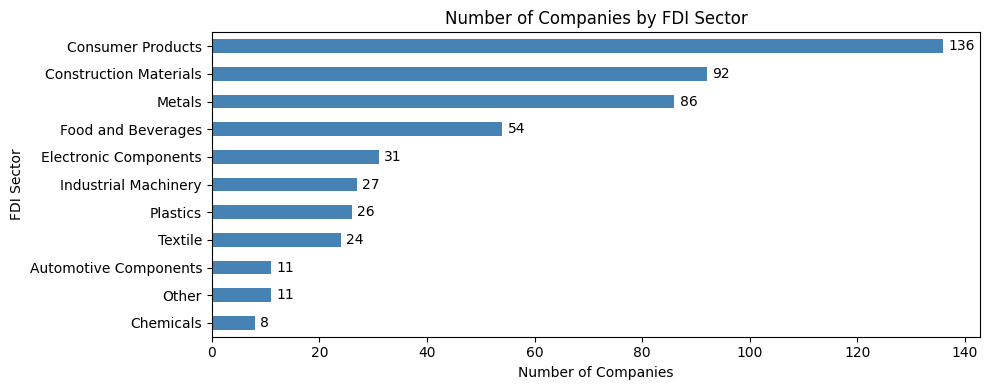

In [14]:
# Count companies by FDI sector
sector_counts = df_renamed["sector_map"].value_counts().sort_values()

# Plot with horizontal bars
ax = sector_counts.plot(kind="barh", figsize=(10, 4), color="steelblue")
plt.title("Number of Companies by FDI Sector")
plt.xlabel("Number of Companies")
plt.ylabel("FDI Sector")

# Add text labels for each bar
for bar in ax.patches:
    count = int(bar.get_width())
    ax.text(bar.get_width() + 1,                   # position a bit to the right
            bar.get_y() + bar.get_height() / 2,    # center vertically
            str(count),
            va='center')

plt.tight_layout()
plt.show()


In [15]:
sector_counts = df_renamed["sector_map"].value_counts().sort_values(ascending=False)
sector_counts

,count
sector_map,
Consumer Products,136
Construction Materials,92
Metals,86
Food and Beverages,54
Electronic Components,31
Industrial Machinery,27
Plastics,26
Textile,24
Other,11


In [16]:
sector_counts.sum()

np.int64(506)

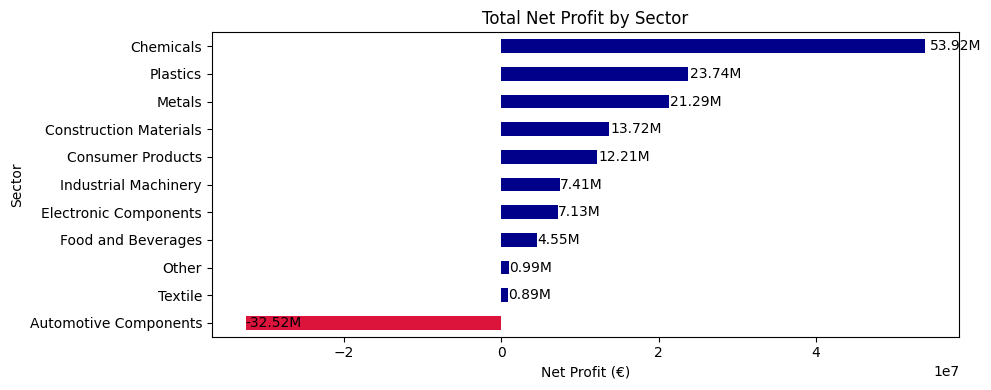

In [17]:
sector_profit = df_renamed.groupby("sector_map")["net_profit"].sum().sort_values(ascending=True)

colors = ['crimson' if val < 0 else 'darkblue' for val in sector_profit]
# Plot
ax = sector_profit.plot(kind="barh", figsize=(10, 4), color=colors)
plt.title("Total Net Profit by Sector")
plt.xlabel("Net Profit (€)")
plt.ylabel("Sector")

# Add value labels in millions
for bar in ax.patches:
    width = bar.get_width()
    ax.text(width + (width * 0.01 if width > 0 else 10000),  # adjust spacing
            bar.get_y() + bar.get_height() / 2,
            f"{width/1_000_000:.2f}M",
            va='center')

plt.tight_layout()
plt.show()

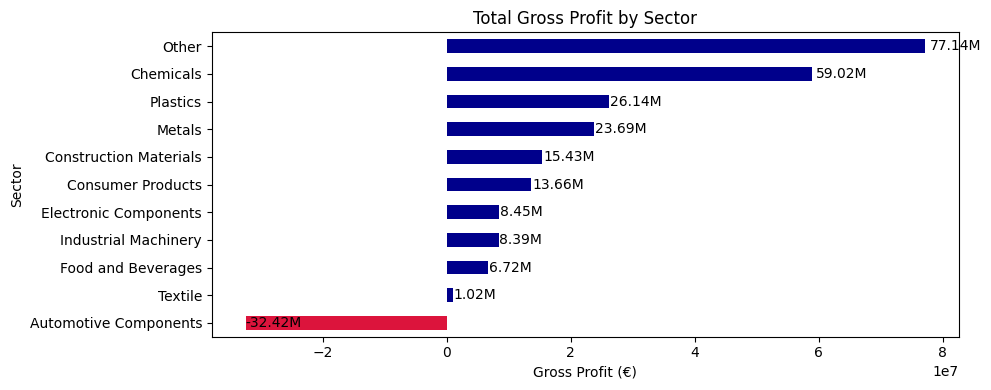

In [18]:
sector_profit = df_renamed.groupby("sector_map")["gross_profit"].sum().sort_values(ascending=True)

colors = ['crimson' if val < 0 else 'darkblue' for val in sector_profit]
# Plot
ax = sector_profit.plot(kind="barh", figsize=(10, 4), color=colors)
plt.title("Total Gross Profit by Sector")
plt.xlabel("Gross Profit (€)")
plt.ylabel("Sector")

# Add value labels in millions
for bar in ax.patches:
    width = bar.get_width()
    ax.text(width + (width * 0.01 if width > 0 else 10000),  # adjust spacing
            bar.get_y() + bar.get_height() / 2,
            f"{width/1_000_000:.2f}M",
            va='center')

plt.tight_layout()
plt.show()

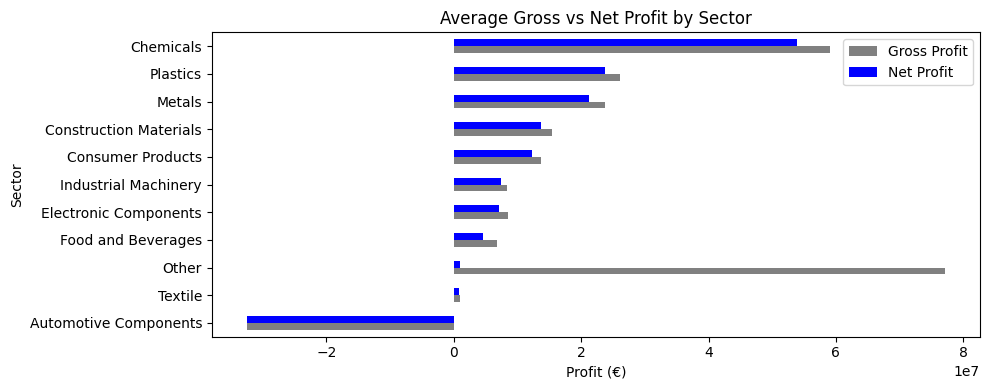

In [19]:
# Group data
sector_profit = df_renamed.groupby("sector_map")[["gross_profit", "net_profit"]].sum().sort_values("net_profit")

# Plot
ax = sector_profit.plot(kind="barh", figsize=(10, 4), color=["gray", "blue"])

# Styling
plt.title("Average Gross vs Net Profit by Sector")
plt.xlabel("Profit (€)")
plt.ylabel("Sector")
plt.legend(["Gross Profit", "Net Profit"])
plt.tight_layout()
plt.show()

In [20]:
def classify_company_size(n):
    if n <= 9:
        return "1–9"
    elif n <= 49:
        return "10–49"
    elif n <= 249:
        return "50–249"
    else:
        return "250+"


In [21]:
df_renamed["company_size_group"] = df_renamed["num_employees"].apply(classify_company_size)

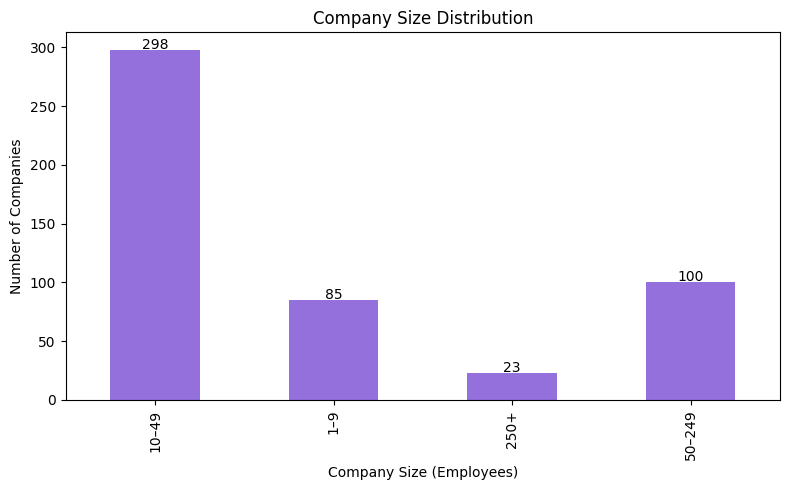

In [22]:
size_distribution = df_renamed["company_size_group"].value_counts().sort_index()

# Plot it
ax = size_distribution.plot(kind="bar", figsize=(8, 5), color="mediumpurple")
plt.title("Company Size Distribution")
plt.xlabel("Company Size (Employees)")
plt.ylabel("Number of Companies")

# Add labels
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
            height + 1,
            str(int(height)),
            ha='center')

plt.tight_layout()
plt.show()


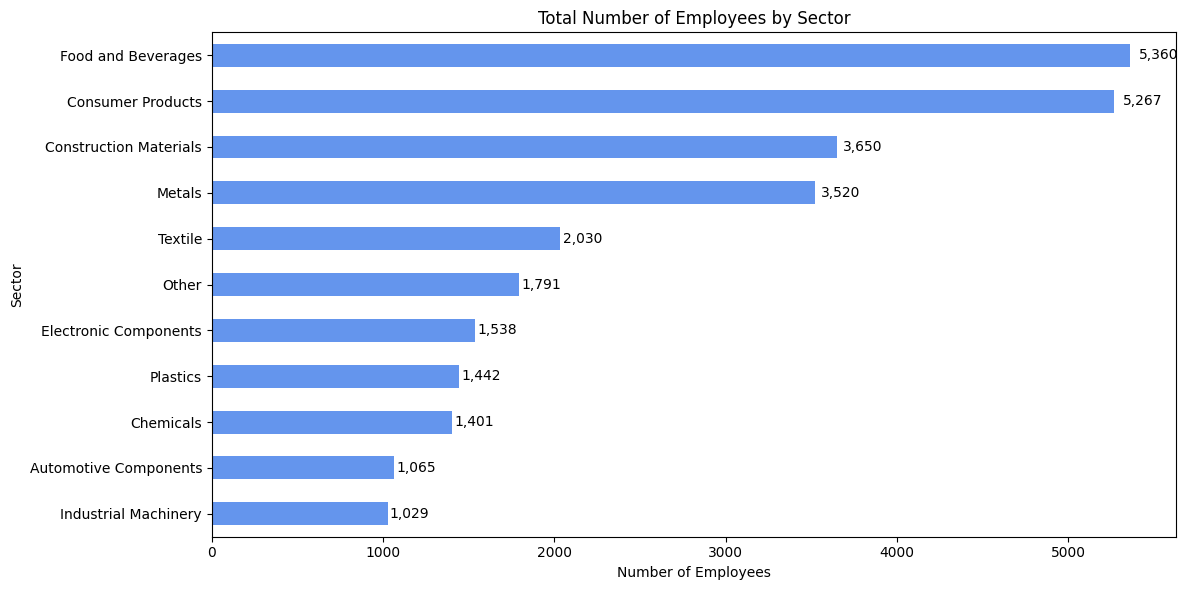

In [23]:

# Prepare data
sector_employees = df_renamed.groupby("sector_map")[["num_employees"]].sum().sort_values("num_employees")

# Plot
ax = sector_employees.plot(kind="barh", figsize=(12, 6), legend=False, color="cornflowerblue")
plt.title("Total Number of Employees by Sector")
plt.xlabel("Number of Employees")
plt.ylabel("Sector")

# Add labels
for bar in ax.patches:
    width = bar.get_width()
    ax.text(width + (width * 0.01 if width > 0 else 100),
            bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}",
            va='center')

plt.tight_layout()
plt.show()


In [24]:
df_renamed

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,ar_maintenance_management,automated_production_lines,autonomous_production_control,autonomous_data_analysis,info_sharing_with_suppliers,collaborative_planning_with_suppliers,system_integration_with_suppliers,sector_name,sector_map,company_size_group
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,2.0,3.0,2.0,2.0,2.0,3.0,Other production,Consumer Products,10–49
1,32.0,NaN,3.0,NaN,7.0,NaN,NaN,3.0,5.0,NaN,...,NaN,NaN,NaN,NaN,2.0,3.0,NaN,Other production,Consumer Products,1–9
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,Other production,Consumer Products,10–49
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,5.0,5.0,NaN,Other production,Consumer Products,50–249
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Other production,Consumer Products,10–49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,11.0,1000000.0,1.0,1.0,7.0,NaN,NaN,2.0,4.0,2.0,...,1.0,1.0,2.0,5.0,2.0,1.0,3.0,Beverage production,Food and Beverages,1–9
502,16.0,815110.0,NaN,3.0,31.0,2215.0,2115.0,NaN,NaN,NaN,...,NaN,NaN,2.0,1.0,3.0,3.0,2.0,Manufacture of wood and of products of wood an...,Construction Materials,10–49
503,13.0,2192224.0,2.0,3.0,61.0,148542.0,148542.0,2.0,2.0,2.0,...,2.0,1.0,4.0,4.0,4.0,3.0,3.0,Production of textile products,Textile,50–249
504,16.0,10964752.0,2.0,4.0,216.0,-190611.0,-190611.0,4.0,4.0,4.0,...,4.0,3.0,4.0,4.0,4.0,3.0,3.0,Manufacture of wood and of products of wood an...,Construction Materials,50–249


In [25]:
df_clean = df_renamed.dropna(subset=["annual_turnover"]).copy()

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[["scaled_turnover", "scaled_employees"]] = scaler.fit_transform(
    df_clean[["annual_turnover", "num_employees"]]
)
df_clean["performance_score"] = df_clean[["scaled_turnover", "scaled_employees"]].mean(axis=1)


In [27]:
# Top 25% based on performance_score
threshold = df_clean["performance_score"].quantile(0.75)

df_clean["performance_class"] = df_clean["performance_score"].apply(
    lambda x: "Top Performing" if x >= threshold else "Other"
)


Text(0.5, 1.0, 'Size Score Distribution (Turnover + Employees)')

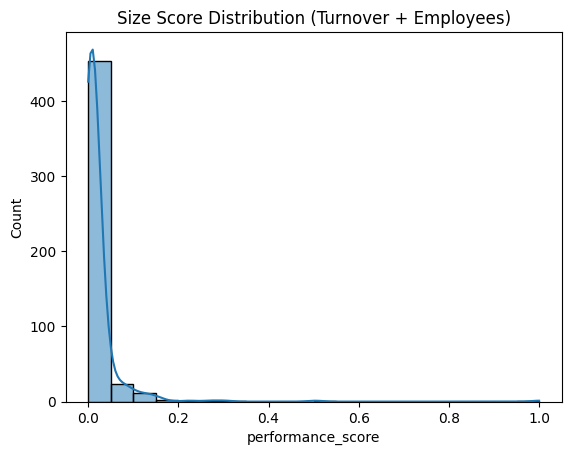

In [28]:
import seaborn as sns
sns.histplot(df_clean["performance_score"], bins=20, kde=True)
plt.title("Size Score Distribution (Turnover + Employees)")


In [29]:
df_clean.head()

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,info_sharing_with_suppliers,collaborative_planning_with_suppliers,system_integration_with_suppliers,sector_name,sector_map,company_size_group,scaled_turnover,scaled_employees,performance_score,performance_class
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,2.0,3.0,Other production,Consumer Products,10–49,0.000252,0.010593,0.005422,Other
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,NaN,Other production,Consumer Products,10–49,0.000211,0.008475,0.004343,Other
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,5.0,5.0,NaN,Other production,Consumer Products,50–249,0.001524,0.050141,0.025833,Top Performing
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,1.0,Other production,Consumer Products,10–49,0.000900,0.031780,0.016340,Other
5,32.0,752837.0,4.0,3.0,44.0,NaN,NaN,2.0,4.0,3.0,...,2.0,4.0,2.0,Other production,Consumer Products,10–49,0.000176,0.030367,0.015272,Other


<ipython-input-30-2c9dfa7e04ba>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_clean, x="performance_class", palette="viridis")


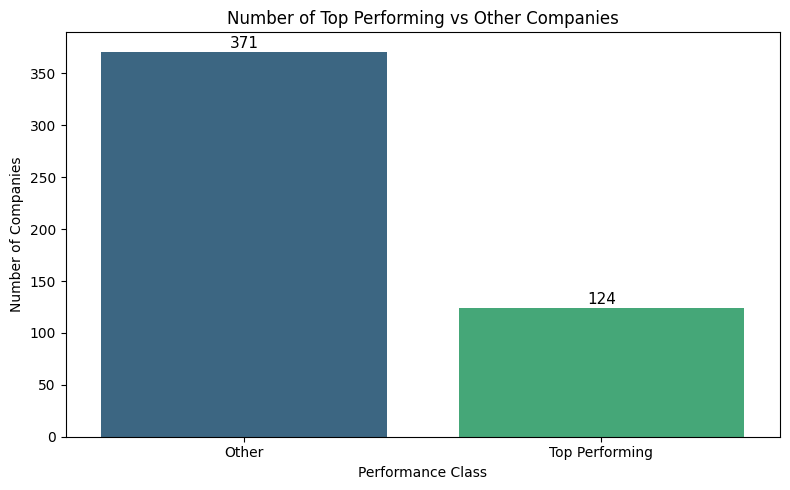

In [30]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_clean, x="performance_class", palette="viridis")

# Add labels on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height() + 1,
            str(count),
            ha='center', va='bottom', fontsize=11)

# Set titles and labels
plt.title("Number of Top Performing vs Other Companies")
plt.xlabel("Performance Class")
plt.ylabel("Number of Companies")
plt.tight_layout()
plt.show()

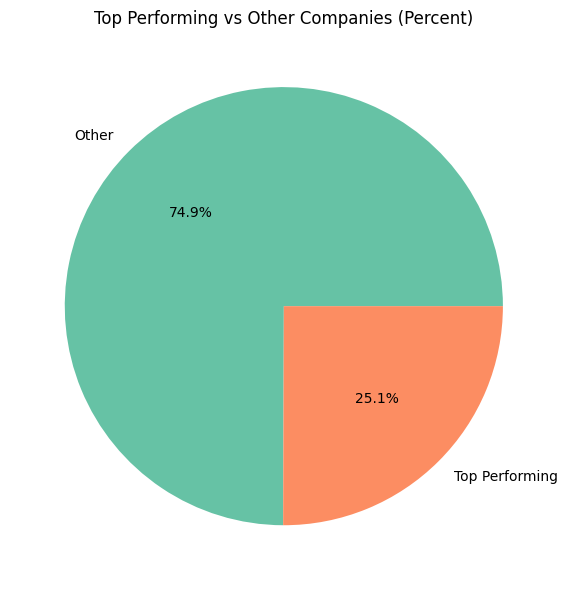

In [31]:
# Count and calculate percentages
performance_counts = df_clean["performance_class"].value_counts()
performance_percent = performance_counts / performance_counts.sum() * 100

# Plot as pie chart
plt.figure(figsize=(6, 6))
plt.pie(performance_percent, labels=performance_percent.index, autopct="%.1f%%", colors=["#66c2a5", "#fc8d62"])
plt.title("Top Performing vs Other Companies (Percent)")

plt.tight_layout()
plt.show()


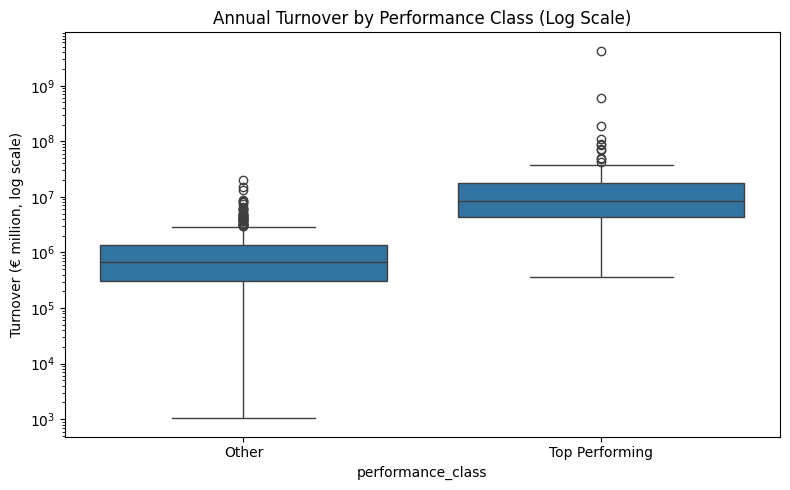

In [32]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clean, x="performance_class", y="annual_turnover")
plt.yscale("log")  # 🔍 Compresses large values
plt.title("Annual Turnover by Performance Class (Log Scale)")
plt.ylabel("Turnover (€ million, log scale)")
plt.tight_layout()
plt.show()


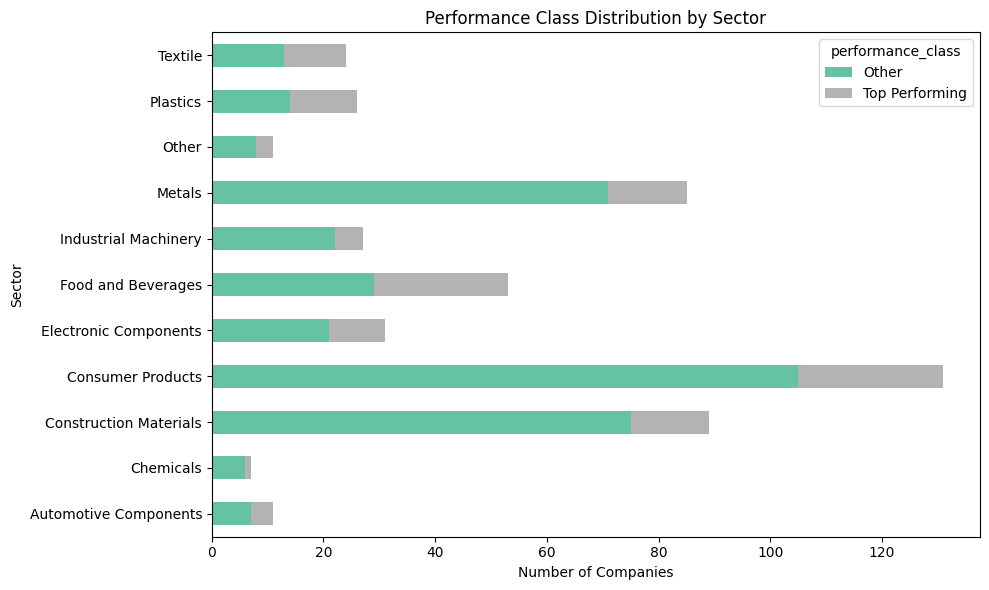

In [33]:
pd.crosstab(df_clean["sector_map"], df_clean["performance_class"]).plot(
    kind="barh", stacked=True, figsize=(10, 6), colormap="Set2"
)
plt.title("Performance Class Distribution by Sector")
plt.xlabel("Number of Companies")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()


In [34]:
digital_df = df_clean.copy()

In [35]:
digital_functions = {
    "Production Planning and Control": [
        "ERP production_planning_software",      # Q018.1
        "order_tracking_software",               # Q018.2
        "MES integrated_operations_software"     # Q018.3
    ],
    "Automation and Robotics": [
        "industrial_robots_usage",               # Q019.1
        "collaborative_robots_usage",            # Q019.2
        "process_automation"                     # Q019.3
    ],
    "Design and Prototyping": [
        "cad_software_usage",                    # Q020.1
        "cnc_equipment_usage",                   # Q020.2
        "3d_printing_prototyping"                # Q020.3
    ],
    "Human-Machine Interaction (HMI)": [
        "shopfloor_tablet_use",                  # Q021.1
        "interactive_production_instructions",   # Q021.2
        "paperless_production",                  # Q021.3
        "ar_asset_identification",               # Q026.1
        "ar_training",                           # Q026.2
        "ar_maintenance_management"              # Q026.3
    ],
    "Data Management and Analytics": [
        "inventory_tracking_raw_materials",      # Q022.1
        "automatic_ordering_solutions",          # Q022.2
        "inventory_tracking_finished_goods",     # Q022.3
        "work_center_data_collection",           # Q023.1
        "wip_tracking_rfid_barcode",             # Q023.2
        "downtime_data_collection",              # Q023.3
        "ai_quality_control",                    # Q024.1
        "ai_demand_forecasting",                 # Q024.2
        "ai_predictive_maintenance",             # Q024.3
        "simulation_root_cause_analysis",        # Q025.1
        "process_mining",                        # Q025.2
        "simulation_schedule_prediction"         # Q025.3
    ],
    "Supply Chain Integration": [
        "info_sharing_with_suppliers",           # Q028.1
        "collaborative_planning_with_suppliers", # Q028.2
        "system_integration_with_suppliers"      # Q028.3
    ]
}


In [36]:
digital_df

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,info_sharing_with_suppliers,collaborative_planning_with_suppliers,system_integration_with_suppliers,sector_name,sector_map,company_size_group,scaled_turnover,scaled_employees,performance_score,performance_class
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,2.0,3.0,Other production,Consumer Products,10–49,0.000252,0.010593,0.005422,Other
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,NaN,Other production,Consumer Products,10–49,0.000211,0.008475,0.004343,Other
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,5.0,5.0,NaN,Other production,Consumer Products,50–249,0.001524,0.050141,0.025833,Top Performing
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,1.0,Other production,Consumer Products,10–49,0.000900,0.031780,0.016340,Other
5,32.0,752837.0,4.0,3.0,44.0,NaN,NaN,2.0,4.0,3.0,...,2.0,4.0,2.0,Other production,Consumer Products,10–49,0.000176,0.030367,0.015272,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,11.0,1000000.0,1.0,1.0,7.0,NaN,NaN,2.0,4.0,2.0,...,2.0,1.0,3.0,Beverage production,Food and Beverages,1–9,0.000234,0.004237,0.002236,Other
502,16.0,815110.0,NaN,3.0,31.0,2215.0,2115.0,NaN,NaN,NaN,...,3.0,3.0,2.0,Manufacture of wood and of products of wood an...,Construction Materials,10–49,0.000191,0.021186,0.010689,Other
503,13.0,2192224.0,2.0,3.0,61.0,148542.0,148542.0,2.0,2.0,2.0,...,4.0,3.0,3.0,Production of textile products,Textile,50–249,0.000514,0.042373,0.021443,Top Performing
504,16.0,10964752.0,2.0,4.0,216.0,-190611.0,-190611.0,4.0,4.0,4.0,...,4.0,3.0,3.0,Manufacture of wood and of products of wood an...,Construction Materials,50–249,0.002571,0.151836,0.077204,Top Performing


In [37]:
# Bin turnover into revenue groups (optional tuning)
digital_df["revenue_group"] = pd.qcut(
    digital_df["annual_turnover"],
    q=4,
    labels=["Low", "Medium", "High", "Very High"]
)


In [38]:
question_groups = {
    "Q018": ["ERP production_planning_software", "order_tracking_software", "MES integrated_operations_software"],
    "Q019": ["industrial_robots_usage", "collaborative_robots_usage", "process_automation"],
    "Q020": ["cad_software_usage", "cnc_equipment_usage", "3d_printing_prototyping"],
    "Q021": ["shopfloor_tablet_use", "interactive_production_instructions", "paperless_production"],
    "Q022": ["inventory_tracking_raw_materials", "automatic_ordering_solutions", "inventory_tracking_finished_goods"],
    "Q023": ["work_center_data_collection", "wip_tracking_rfid_barcode", "downtime_data_collection"],
    "Q024": ["ai_quality_control", "ai_demand_forecasting", "ai_predictive_maintenance"],
    "Q025": ["simulation_root_cause_analysis", "process_mining", "simulation_schedule_prediction"],
    "Q026": ["ar_asset_identification", "ar_training", "ar_maintenance_management"],
    "Q027": ["automated_production_lines", "autonomous_production_control", "autonomous_data_analysis"],
    "Q028": ["info_sharing_with_suppliers", "collaborative_planning_with_suppliers", "system_integration_with_suppliers"]
}


In [39]:
for group, cols in question_groups.items():
    for col in cols:
        digital_df[col] = digital_df.groupby(
            ["sector_map", "company_size_group", "revenue_group"], observed=True
        )[col].transform(lambda x: x.fillna(x.median()))


In [40]:
digital_df

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,collaborative_planning_with_suppliers,system_integration_with_suppliers,sector_name,sector_map,company_size_group,scaled_turnover,scaled_employees,performance_score,performance_class,revenue_group
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,2.0,3.0,Other production,Consumer Products,10–49,0.000252,0.010593,0.005422,Other,High
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,1.0,2.0,Other production,Consumer Products,10–49,0.000211,0.008475,0.004343,Other,Medium
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,5.0,2.0,Other production,Consumer Products,50–249,0.001524,0.050141,0.025833,Top Performing,Very High
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,1.0,1.0,Other production,Consumer Products,10–49,0.000900,0.031780,0.016340,Other,High
5,32.0,752837.0,4.0,3.0,44.0,NaN,NaN,2.0,4.0,3.0,...,4.0,2.0,Other production,Consumer Products,10–49,0.000176,0.030367,0.015272,Other,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,11.0,1000000.0,1.0,1.0,7.0,NaN,NaN,2.0,4.0,2.0,...,1.0,3.0,Beverage production,Food and Beverages,1–9,0.000234,0.004237,0.002236,Other,Medium
502,16.0,815110.0,NaN,3.0,31.0,2215.0,2115.0,2.0,2.0,2.0,...,3.0,2.0,Manufacture of wood and of products of wood an...,Construction Materials,10–49,0.000191,0.021186,0.010689,Other,Medium
503,13.0,2192224.0,2.0,3.0,61.0,148542.0,148542.0,2.0,2.0,2.0,...,3.0,3.0,Production of textile products,Textile,50–249,0.000514,0.042373,0.021443,Top Performing,High
504,16.0,10964752.0,2.0,4.0,216.0,-190611.0,-190611.0,4.0,4.0,4.0,...,3.0,3.0,Manufacture of wood and of products of wood an...,Construction Materials,50–249,0.002571,0.151836,0.077204,Top Performing,Very High


In [41]:
# Fallback: fill remaining with median of the full column
for col in sum(question_groups.values(), []):
    digital_df[col] = digital_df[col].fillna(digital_df[col].median())


In [42]:
digital_df.isna().sum()

,0
sector,0
annual_turnover,0
return_on_sales,133
exports_percent,100
num_employees,0
gross_profit,134
net_profit,134
ERP production_planning_software,0
order_tracking_software,0
MES integrated_operations_software,0


In [43]:
digital_dfc = digital_df.copy()

In [44]:
# Use the digital_functions dict (already mapped earlier)
for func, cols in digital_functions.items():
    digital_dfc[f"{func}_score"] = digital_dfc[cols].mean(axis=1)


In [45]:
function_score_cols = [f"{func}_score" for func in digital_functions]
digital_dfc["digitalization_score"] = digital_dfc[function_score_cols].mean(axis=1)


In [46]:
def classify_digital_level(score):
    if score >= 4:
        return "High"
    elif score >= 2.5:
        return "Medium"
    else:
        return "Low"

digital_dfc["digitalization_level"] = digital_dfc["digitalization_score"].apply(classify_digital_level)


In [47]:
digital_dfc

,sector,annual_turnover,return_on_sales,exports_percent,num_employees,gross_profit,net_profit,ERP production_planning_software,order_tracking_software,MES integrated_operations_software,...,performance_class,revenue_group,Production Planning and Control_score,Automation and Robotics_score,Design and Prototyping_score,Human-Machine Interaction (HMI)_score,Data Management and Analytics_score,Supply Chain Integration_score,digitalization_score,digitalization_level
0,32.0,1073924.0,3.0,3.0,16.0,36551.0,30752.0,2.0,4.0,4.0,...,Other,High,3.333333,2.333333,3.000000,2.333333,2.333333,2.333333,2.611111,Medium
2,32.0,900000.0,5.0,4.0,13.0,NaN,NaN,1.0,1.0,1.0,...,Other,Medium,1.000000,2.333333,2.000000,1.666667,1.000000,1.333333,1.555556,Low
3,32.0,6500000.0,4.0,4.0,72.0,NaN,NaN,5.0,4.0,5.0,...,Top Performing,Very High,4.666667,2.333333,4.333333,2.750000,3.041667,4.000000,3.520833,Medium
4,32.0,3839360.0,5.0,2.0,46.0,327308.0,273056.0,1.0,5.0,5.0,...,Other,High,3.666667,1.000000,3.333333,2.166667,1.416667,1.000000,2.097222,Low
5,32.0,752837.0,4.0,3.0,44.0,NaN,NaN,2.0,4.0,3.0,...,Other,Medium,3.000000,4.333333,3.333333,3.666667,4.000000,2.666667,3.500000,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,11.0,1000000.0,1.0,1.0,7.0,NaN,NaN,2.0,4.0,2.0,...,Other,Medium,2.666667,1.000000,1.333333,1.833333,1.833333,2.000000,1.777778,Low
502,16.0,815110.0,NaN,3.0,31.0,2215.0,2115.0,2.0,2.0,2.0,...,Other,Medium,2.000000,1.666667,4.000000,2.000000,1.916667,2.666667,2.375000,Low
503,13.0,2192224.0,2.0,3.0,61.0,148542.0,148542.0,2.0,2.0,2.0,...,Top Performing,High,2.000000,2.000000,1.333333,2.666667,2.708333,3.333333,2.340278,Low
504,16.0,10964752.0,2.0,4.0,216.0,-190611.0,-190611.0,4.0,4.0,4.0,...,Top Performing,Very High,4.000000,3.000000,4.000000,3.833333,3.125000,3.333333,3.548611,Medium


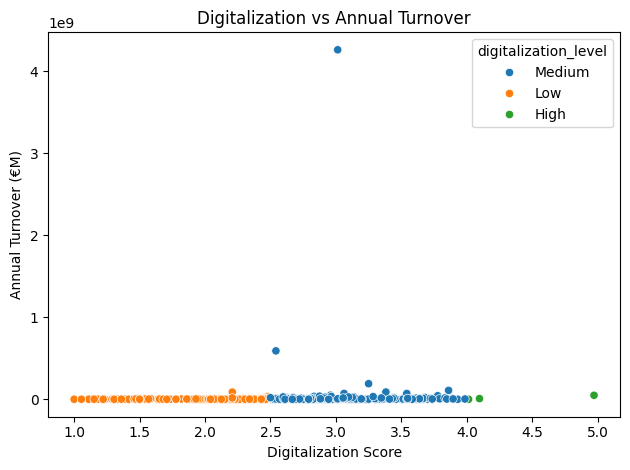

In [48]:
sns.scatterplot(data=digital_dfc, x="digitalization_score", y="annual_turnover", hue="digitalization_level")
plt.title("Digitalization vs Annual Turnover")
plt.xlabel("Digitalization Score")
plt.ylabel("Annual Turnover (€M)")
plt.tight_layout()
plt.show()


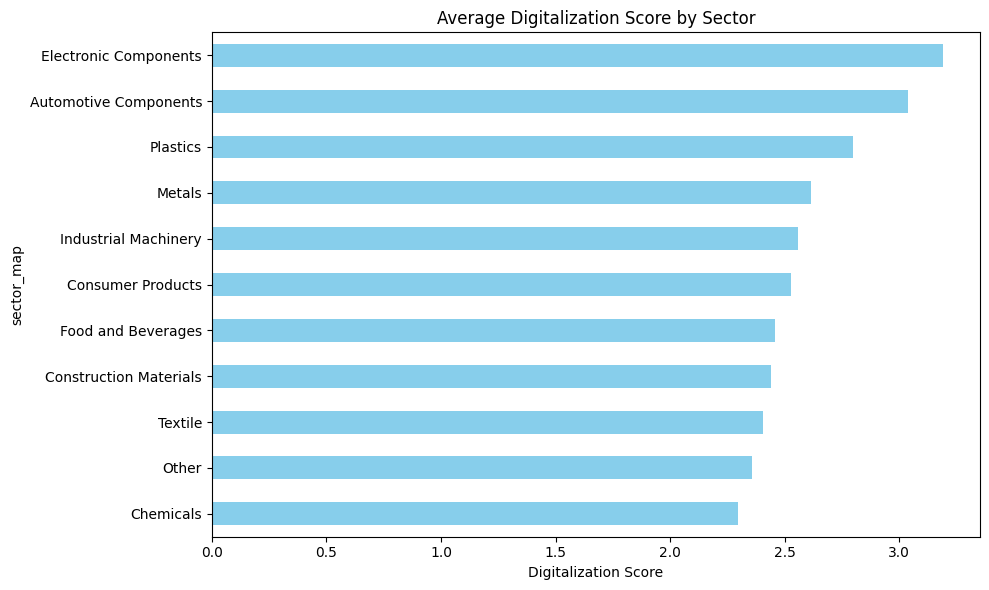

In [49]:
sector_digi = digital_dfc.groupby("sector_map")["digitalization_score"].mean().sort_values()

sector_digi.plot(kind="barh", figsize=(10, 6), color="skyblue")
plt.title("Average Digitalization Score by Sector")
plt.xlabel("Digitalization Score")
plt.tight_layout()
plt.show()


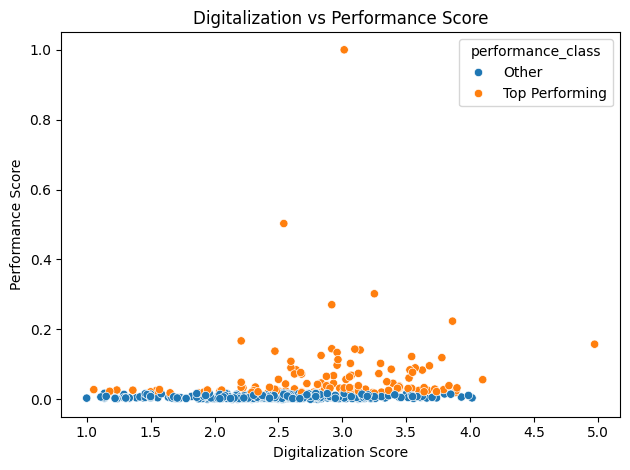

In [50]:
sns.scatterplot(data=digital_dfc, x="digitalization_score", y="performance_score", hue="performance_class")
plt.title("Digitalization vs Performance Score")
plt.xlabel("Digitalization Score")
plt.ylabel("Performance Score")
plt.tight_layout()
plt.show()


In [51]:
function_score_cols = [f"{func}_score" for func in digital_functions]


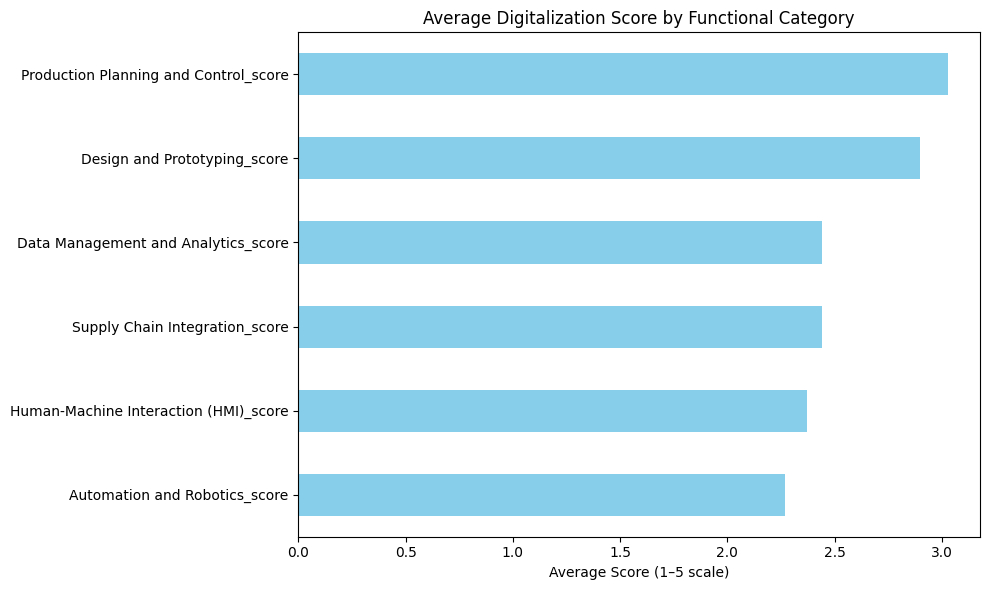

In [54]:
# Average digitalization score per function
function_means = digital_dfc[function_score_cols].mean().sort_values()

plt.figure(figsize=(10, 6))
function_means.plot(kind="barh", color="skyblue")
plt.title("Average Digitalization Score by Functional Category")
plt.xlabel("Average Score (1–5 scale)")
plt.tight_layout()
plt.show()


<ipython-input-55-d5d4d68add19>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Function", y="Score", palette="coolwarm")


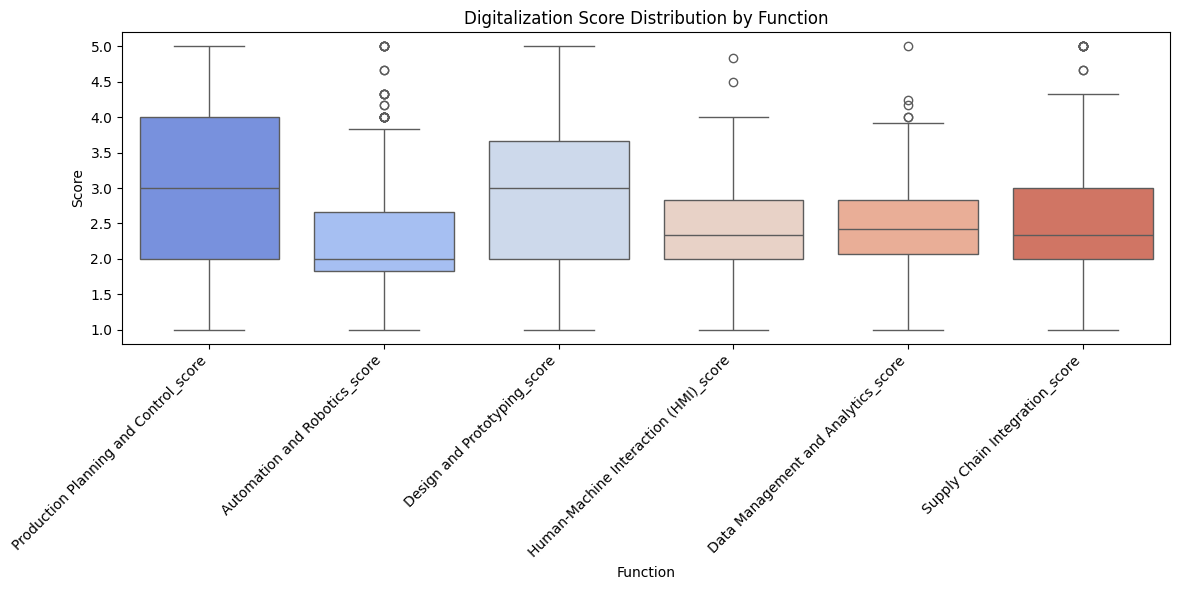

In [55]:

# Melt for seaborn boxplot format
df_melted = digital_dfc[function_score_cols].melt(var_name="Function", value_name="Score")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Function", y="Score", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Digitalization Score Distribution by Function")
plt.tight_layout()
plt.show()


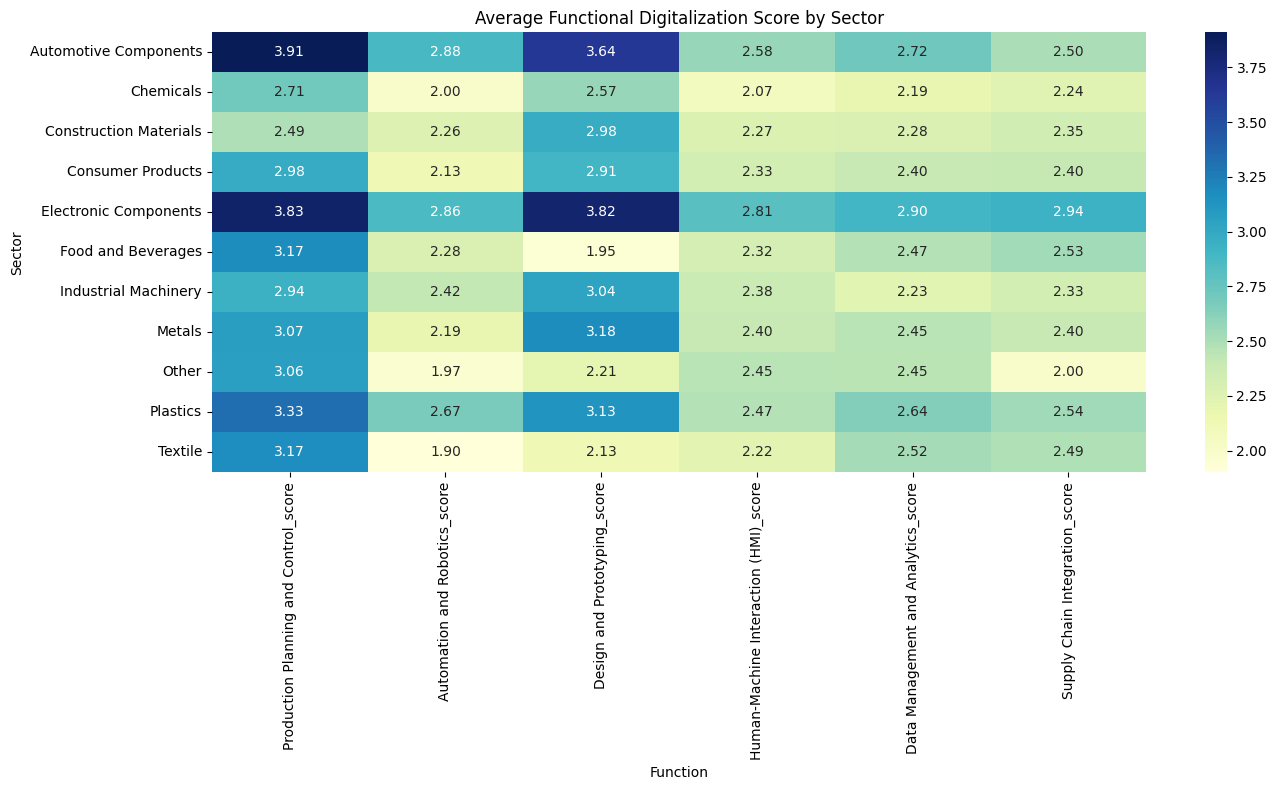

In [56]:


# Group by sector_map and get mean functional scores
sector_func_scores = digital_dfc.groupby("sector_map")[function_score_cols].mean()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(sector_func_scores, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Average Functional Digitalization Score by Sector")
plt.xlabel("Function")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()


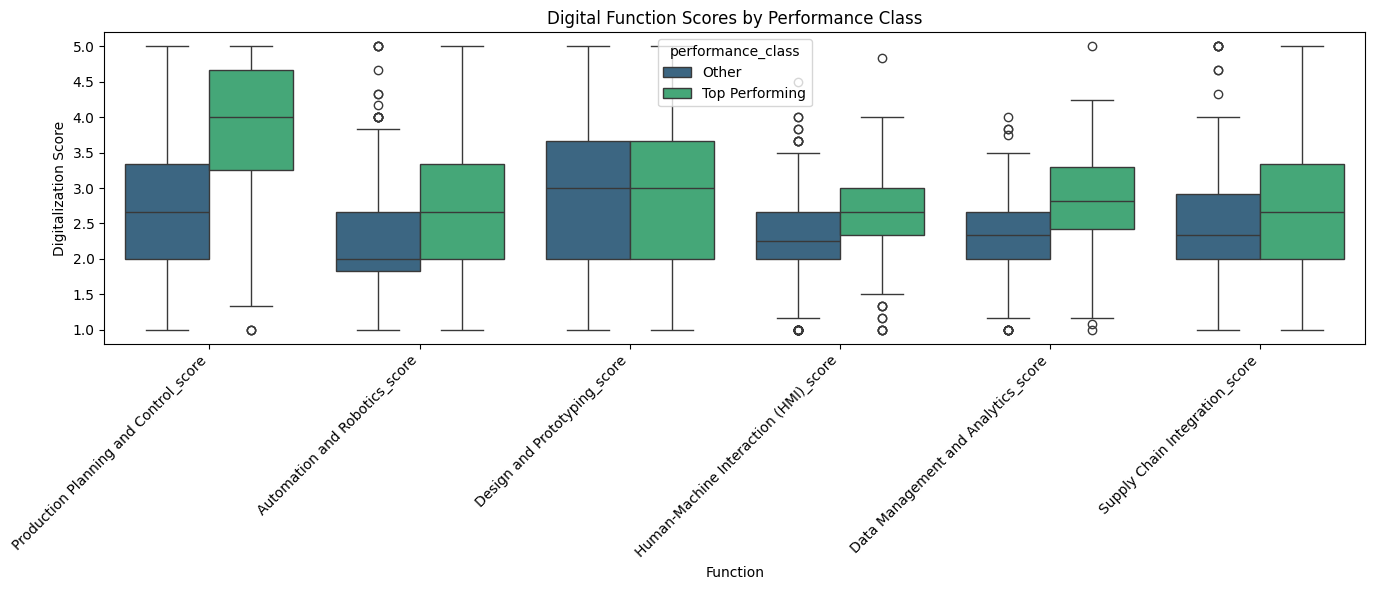

In [57]:

# Melt data for seaborn
df_melted = digital_dfc.melt(
    id_vars="performance_class",
    value_vars=function_score_cols,
    var_name="Function",
    value_name="Score"
)

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_melted, x="Function", y="Score", hue="performance_class", palette="viridis")
plt.title("Digital Function Scores by Performance Class")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Digitalization Score")
plt.tight_layout()
plt.show()


In [58]:
# Select numeric columns for correlation
correlation_cols = function_score_cols + [
    "digitalization_score",
    "performance_score",
    "annual_turnover",
]

# Compute correlation matrix
corr_matrix = digital_dfc[correlation_cols].corr()


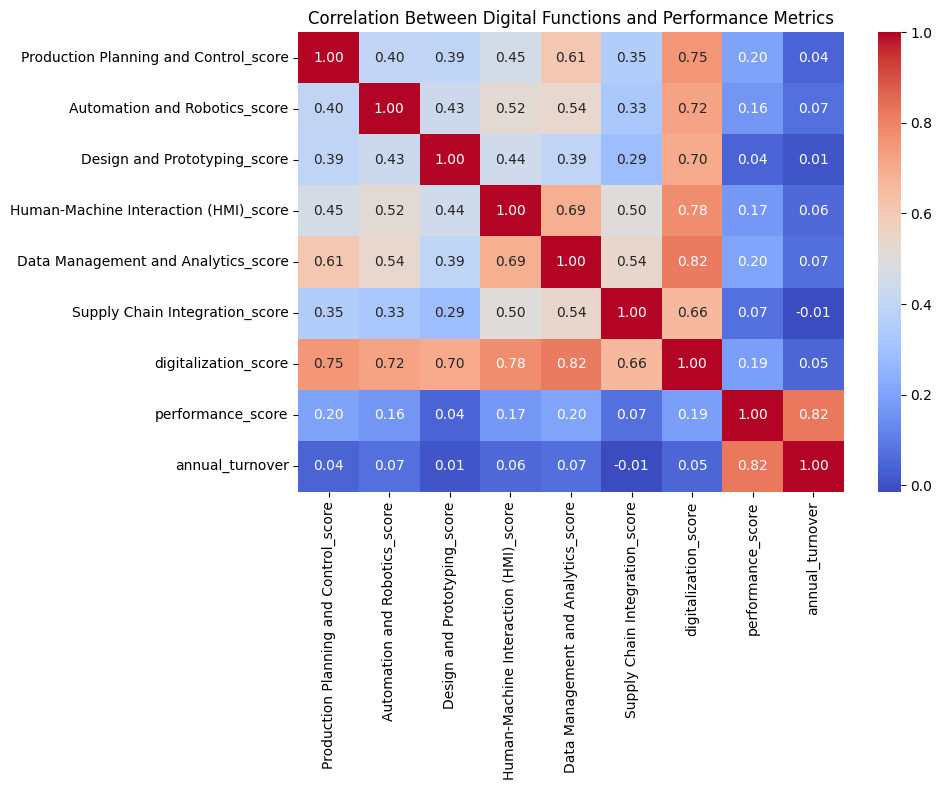

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Digital Functions and Performance Metrics")
plt.tight_layout()
plt.show()


<ipython-input-60-1cc9a9d0b78a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=digital_dfc, x="company_size_group", y="digitalization_score", palette="Spectral")


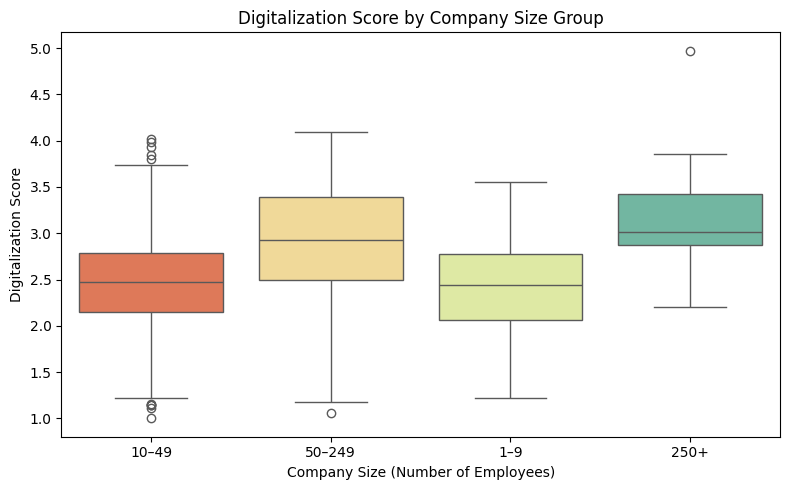

In [60]:


plt.figure(figsize=(8, 5))
sns.boxplot(data=digital_dfc, x="company_size_group", y="digitalization_score", palette="Spectral")
plt.title("Digitalization Score by Company Size Group")
plt.xlabel("Company Size (Number of Employees)")
plt.ylabel("Digitalization Score")
plt.tight_layout()
plt.show()


In [61]:
# Group by company size group and calculate mean for each function
size_func_scores = digital_dfc.groupby("company_size_group")[function_score_cols].mean()


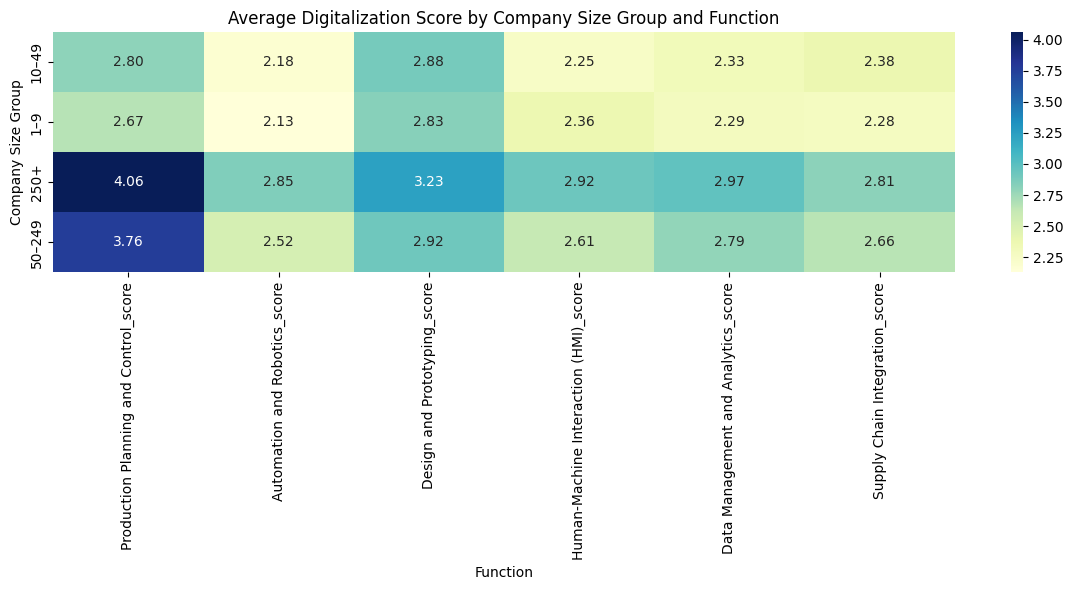

In [62]:


plt.figure(figsize=(12, 6))
sns.heatmap(size_func_scores, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Digitalization Score by Company Size Group and Function")
plt.xlabel("Function")
plt.ylabel("Company Size Group")
plt.tight_layout()
plt.show()
